### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math

import OSS as oss
import BPD as bpd
import accumulate as acc
import detectbeat as db
import plotters

### 1. Onset Signal Strength (OSS)

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
#plot_signal(data=data, sr=sr, stop=6, title="Raw Signal")

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10944 frames
returned frame count: 10944 frames
(10944, 1024)


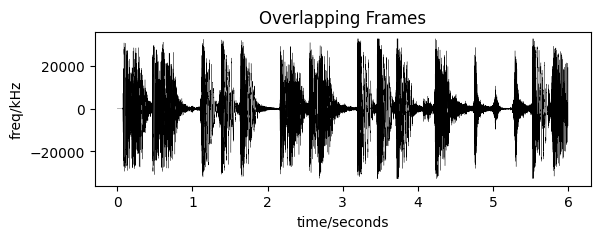

In [3]:
framesize = 1024
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
print(frames.shape)
plotters.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

#### Log power spectrum

In [4]:
# multiplying by the hamming window function
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)

# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames, n=framesize, axis=1)
fft_frames6 = scipy.fftpack.fft(x=tappered_frames6, n=framesize, axis=1)

In [5]:
log_power = oss.comp_log_power(fft_frames)
log_power6 = oss.comp_log_power(fft_frames6)

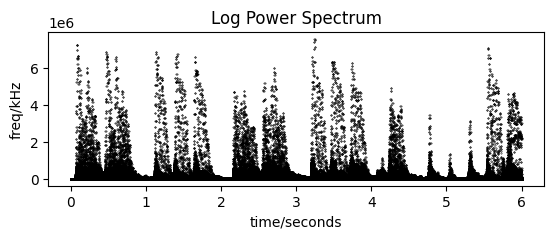

In [6]:
plotters.plot_log_spectrum(abs(fft_frames6), framesize=framesize, hop=hop, sr=44100)

#### Flux

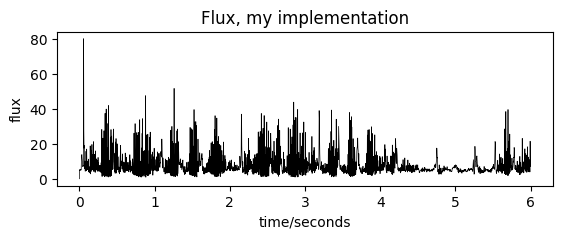

In [7]:
flux = oss.comp_flux(log_power)
flux6 = oss.comp_flux(log_power6)
plotters.plot_flux(flux6, title="Flux, my implementation")

#### Low-pass filter

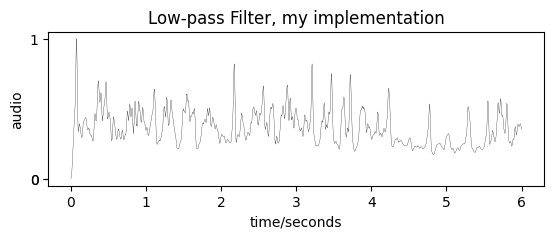

In [8]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
plotters.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter, my implementation")

### Step 2: Beat Period Detection

#### Overlap

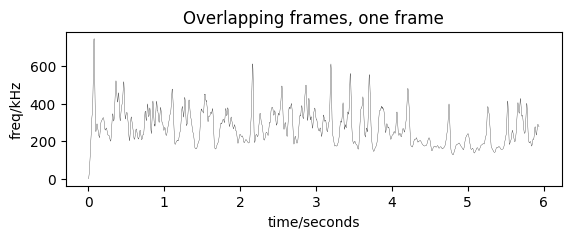

In [9]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
plotters.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames, one frame")

#### Generalized Autocorrelation

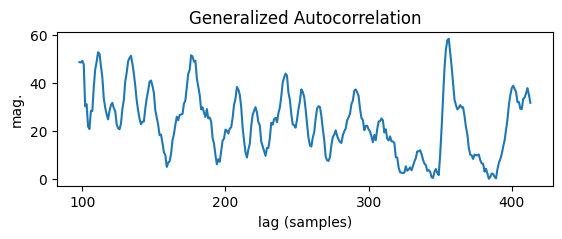

In [10]:
A = bpd.autocorrelation(signal=frames)
plotters.plot_correlation(A=A[0], title="Generalized Autocorrelation")

#### Enhance Harmonics

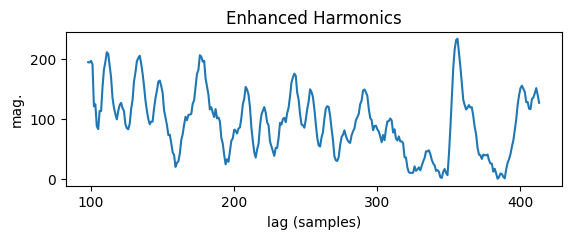

In [11]:
EAC = bpd.enhance_harmonics(A=A)
plotters.plot_correlation(A=EAC[0], title="Enhanced Harmonics")

#### Pick Peaks

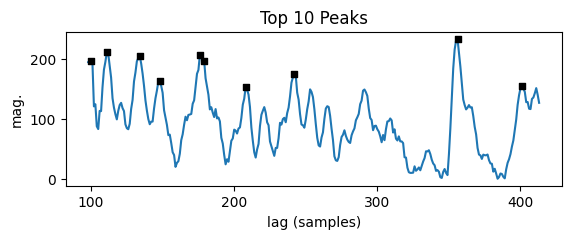

In [12]:
indices, values = bpd.pick_peaks(A=A)
idx = 0
plotters.plot_correlation(A=A[0], start=98+316*idx, stop=414+316*idx, indices=indices[idx], values=values[idx], title="Top 10 Peaks")

#### Evaluate Pulse Train

In [13]:
Lm = bpd.evaluate_pulse_train(indices[0], frames[0])
print(f"{int(round(344.5*60/Lm, 0))} bpm")

68 bpm


### Step 3: Accumulation and overall estimate

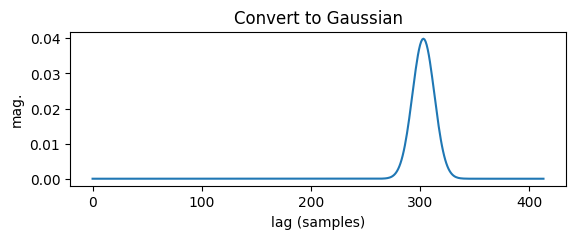

In [14]:
plotters.plot_gaussian(Lm=Lm.tolist(), g=acc.Gm, title="Convert to Gaussian")

overall estimate: 211 bpm


c:\Users\hitts\Documents\GitHub\beat\src\BPD.py:118: RuntimeWarning: invalid value encountered in divide
  return SCv/np.linalg.norm(SCv), SCx/np.linalg.norm(SCx)


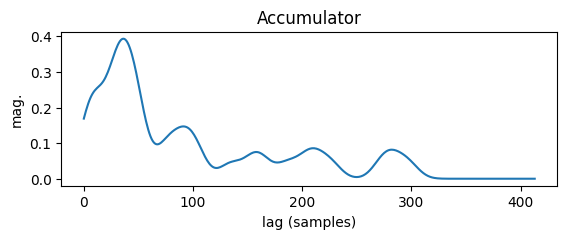

In [15]:
Lms = acc.eval_entire_signal(indices, frames)
y = acc.accumulate_gauss(Lms=Lms)
idxs, vals = bpd.find_local_maximums(np.concatenate((np.zeros(98), y[98:])))
print(f"overall estimate: {int(round(344.5*60/idxs[-1], 0))} bpm")
plotters.plot_gaussian(Lm=y, g=acc.Gm, title="Accumulator")

In [17]:
beat_estiamte = round(db.run_beat_detection(filepath="ballroom.wav", framesize=256, hop=128))
print(f"beat estimate with window size 256 samples: {beat_estiamte} bpm")

beat estimate with window size 256 samples: 183 bpm
